In [1]:
!pip install tensorflow_addons
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 7.2 MB/s eta 0:00:00


In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from kerastuner import RandomSearch

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
<ipython-input-2-4927589ade63>:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [3]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar100.load_data()
# Normalize data
x_train = X_train.astype('float32') / 255.0
x_test = X_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices
num_classes = 100
y_train = to_categorical(Y_train, num_classes)
y_test = to_categorical(Y_test, num_classes)

169001437/169001437 [==============================] - 4s 0us/step


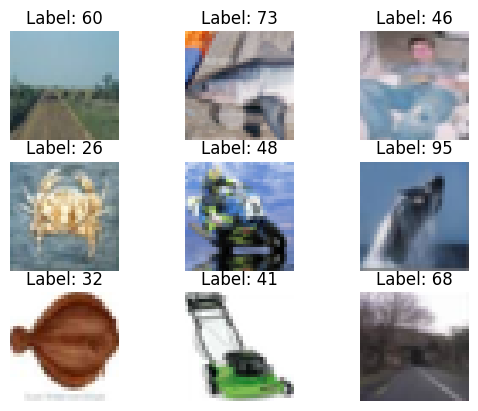

In [10]:
# Choose 9 random images
import numpy as np
indices = np.random.randint(0, x_train.shape[0], 9)
images = x_train[indices]
labels = Y_train[indices]

# Plot the images
fig, axes = plt.subplots(3, 3)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i][0]}")
    ax.axis("off")

plt.show()

In [5]:
def multilayer_perceptron(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
def patchImage(patch_size,images):
  batch_size = tf.shape(images)[0]
  patches = tf.image.extract_patches(
            images=images,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
  patch_dims = patches.shape[-1]
  patches = tf.reshape(patches, [batch_size, -1, patch_dims])
  return patches

In [7]:
def patchEncoder(num_patches,nuberNuron,patch):
    projection = layers.Dense(units=nuberNuron)
    position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=nuberNuron
        )
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded = projection(patch) + position_embedding(positions)
    return encoded

In [ ]:
def vision_transformer(hp):

    projection_dim = hp.Choice('projection_dim', values=[32, 64, 128, 256])
    patch_size = hp.Choice('patch_size', values=[6, 8, 9, 12])
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    transformer_block = hp.Choice('transformer_block', values=[6,8,12])
    mlp_head_units = [2048, 1024] 
    transformer_units = [
        projection_dim * 2,
        projection_dim * 2,
        projection_dim,
    ]  # Size of the transformer layers
    num_patches = (72 // patch_size) ** 2


    inputs = keras.Input(shape=(32, 32, 3))
    resized_image = layers.experimental.preprocessing.Resizing(72, 72)(inputs)

    patches = patchImage(patch_size,resized_image)

    encoded_patches = patchEncoder(num_patches, projection_dim,patches)



    # Transformer blocks
    for _ in range(transformer_block):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        x3 = multilayer_perceptron(x3, hidden_units=transformer_units, dropout_rate=0.2)

        encoded_patches = layers.Add()([x3, x2])


    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = multilayer_perceptron(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    outputs = layers.Dense(100, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=0.0001
    )
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
tuner = RandomSearch(
    vision_transformer,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='cifar100_vit_tuning',
    project_name='ViT_hyperparam_tuning'
)
tuner.search(x_train, y_train, epochs=30, validation_split=0.1, batch_size=64)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)
# best_model = tuner.get_best_models(num_models=1)[0]

In [8]:
input_shape = (32, 32, 3)
num_classes = 100
projection_dim = 64
num_heads = 4
patch_size = 6
num_transformer_blocks = 6
mlp_head_units = [2048, 1024] 
transformer_units = [
    projection_dim * 2,
    projection_dim * 2,
    projection_dim,
]  
num_patches = (72 // patch_size) ** 2

learning_rate = 0.0001


from tensorflow.keras.metrics import top_k_categorical_accuracy


# Define the top-5-accuracy metric
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [9]:
def besst_vision_transformer():


    inputs = keras.Input(shape=input_shape)
    # resized_image = data_augmentation(inputs)
    resized_image = layers.experimental.preprocessing.Resizing(72, 72)(inputs)

    patches = patchImage(patch_size,resized_image)
  
    encoded_patches = patchEncoder(num_patches, projection_dim,patches)



    # Transformer blocks
    for _ in range(num_transformer_blocks):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        x3 = multilayer_perceptron(x3, hidden_units=transformer_units, dropout_rate=0.3)

        encoded_patches = layers.Add()([x3, x2])


    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = multilayer_perceptron(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=0.0001
    )
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy",top_5_accuracy])

    return model

In [10]:
best_model = besst_vision_transformer()
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 72, 72, 3)    0           ['input_1[0][0]']                
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (4,)                0           ['resizing[0][0]']               
 )                                                                                                
                                                                                                  
 tf.image.extract_patches (TFOp  (None, 12, 12, 108)  0          ['resizing[0][0]']           

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_filepath = "/content/drive/MyDrive/Project/checkpoint2.h5"

checkpoint_callback = keras.callbacks.ModelCheckpoint(  
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=3)
# history = best_model.fit(
#     x=x_train,
#     y=y_train,
#     batch_size=256,
#     epochs=45,
#     validation_split=0.1,
#     callbacks=[checkpoint_callback,reduce_lr],
# )

Epoch 1/45
176/176 [==============================] - 69s 339ms/step - loss: 4.7725 - accuracy: 0.0104 - top_5_accuracy: 0.0519 - val_loss: 4.6058 - val_accuracy: 0.0088 - val_top_5_accuracy: 0.0526 - lr: 1.0000e-04
Epoch 2/45
176/176 [==============================] - 55s 313ms/step - loss: 4.6097 - accuracy: 0.0104 - top_5_accuracy: 0.0512 - val_loss: 4.6039 - val_accuracy: 0.0080 - val_top_5_accuracy: 0.0536 - lr: 1.0000e-04
Epoch 3/45
176/176 [==============================] - 57s 325ms/step - loss: 4.6030 - accuracy: 0.0116 - top_5_accuracy: 0.0551 - val_loss: 4.5793 - val_accuracy: 0.0116 - val_top_5_accuracy: 0.0628 - lr: 1.0000e-04
Epoch 4/45
176/176 [==============================] - 58s 329ms/step - loss: 4.5253 - accuracy: 0.0194 - top_5_accuracy: 0.0876 - val_loss: 4.4431 - val_accuracy: 0.0260 - val_top_5_accuracy: 0.1180 - lr: 1.0000e-04
Epoch 5/45
176/176 [==============================] - 58s 331ms/step - loss: 4.4189 - accuracy: 0.0276 - top_5_accuracy: 0.1201 - val_lo

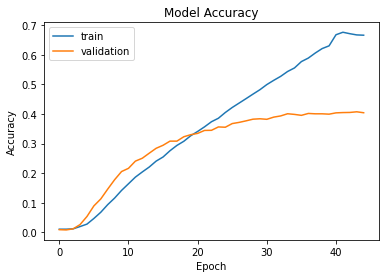

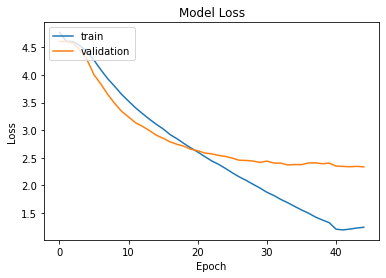

In [23]:
# Plot the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Vit Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Vit Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
best2_model = besst_vision_transformer()
checkpoint_filepath = "/content/drive/MyDrive/Project/checkpoint2.h5"
best2_model.load_weights(checkpoint_filepath)

# _, accuracy = best2_model.evaluate(x_test, y_test)
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
y_pred = best2_model.predict(x_test)
y_pred

313/313 [==============================] - 11s 22ms/step


array([[3.69315416e-07, 5.74995602e-06, 1.58596122e-05, ...,
        2.31350711e-07, 2.84793919e-06, 7.01694298e-05],
       [2.39749115e-05, 3.72961687e-04, 2.85093032e-04, ...,
        6.15313137e-03, 3.90842935e-04, 2.49648892e-05],
       [3.79375069e-06, 4.41497366e-04, 5.97692633e-05, ...,
        1.54518148e-05, 8.19695197e-05, 1.46570574e-06],
       ...,
       [5.43165999e-03, 8.96346100e-05, 1.17324510e-06, ...,
        1.20630125e-06, 6.16943851e-07, 1.68731948e-03],
       [6.32620577e-05, 1.97483550e-05, 3.60663020e-04, ...,
        1.07424660e-02, 2.51937355e-03, 1.50304865e-02],
       [2.15120278e-02, 5.36024664e-03, 4.02402620e-05, ...,
        3.37501298e-08, 3.93498449e-05, 2.93509784e-05]], dtype=float32)

In [14]:

import numpy as np
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
from sklearn.metrics import precision_recall_fscore_support

# Calculate the precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='macro')

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.3969614533305843
Recall: 0.3731000000000001
F1-score: 0.3559674022449179
